<a href="https://colab.research.google.com/github/vishakha711/WeatherPredictionApp/blob/main/WeatherPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Weather Prediction ML model**

## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, classification_report ,confusion_matrix, ConfusionMatrixDisplay

import joblib

### Load Dataset

In [2]:
from google.colab import files
uploaded = files.upload()


Saving archive (1).zip to archive (1).zip


In [3]:
import zipfile
import os

# Get the name of the uploaded zip file
zip_file_name = list(uploaded.keys())[0]

# Extract the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()

csv_file_path = 'seattle-weather.csv'

# Check if the CSV file exists after extraction
if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
    display(df.head())
else:
    print(f"Error: '{csv_file_path}' not found after extraction.")

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [4]:
df.isnull().sum()    #Checking missing values

,0
date,0
precipitation,0
temp_max,0
temp_min,0
wind,0
weather,0


### Feature Enginnering

In [5]:
df['humidity'] = 100 - (df['temp_max'] - df['temp_min']) * 2     # Derive humidity (approx formula)
df['humidity'] = df['humidity'].clip(0, 100)

In [16]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

In [7]:
# Select Features and Targets
features = ['temp_max', 'temp_min', 'precipitation', 'wind', 'humidity', 'day_of_year']
target_numeric = ['temp_max', 'temp_min', 'humidity', 'wind']
target_weather = 'weather'

In [23]:
# ==========================
# Create Lag Features (past 7 days)
# ==========================
for lag in range(1, 15):
    df[f'temp_max_lag_{lag}'] = df['temp_max'].shift(lag)
    df[f'temp_min_lag_{lag}'] = df['temp_min'].shift(lag)
    df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag)
    df[f'wind_lag_{lag}'] = df['wind'].shift(lag)

df = df.dropna().reset_index(drop=True)

In [24]:
# ==========================
# Split Data (Time-based)
# ==========================
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

features = [col for col in df.columns if 'lag' in col]
targets = ['temp_max', 'temp_min', 'humidity', 'wind']

X_train = train[features]
y_train = train[targets]
X_test = test[features]
y_test = test[targets]

In [25]:
# ==========================
# Scaling
# ==========================
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)

### LINEAR REGRESSION (Numeric)

In [26]:
# ==========================
# Train Model
# ==========================
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [27]:
# ==========================
#  Predict & Evaluate
# ==========================
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

In [29]:
print("\nModel Evaluation:")
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


Model Evaluation:
R2 Score: 0.604216472621334
MAE: 2.2141955477132083
MSE: 10.972682786857083


In [33]:
# ==========================
# 7-Day Automatic Forecast
# ==========================
last_known = df.iloc[-14:].copy() # Use last 14 days for forecasting
forecast = []

for i in range(7):
    lag_features = []
    for lag in range(1, 15): # Use 14 days of lag features
        lag_features.extend([
            last_known['temp_max'].iloc[-lag],
            last_known['temp_min'].iloc[-lag],
            last_known['humidity'].iloc[-lag],
            last_known['wind'].iloc[-lag]
        ])
    x_input = np.array(lag_features).reshape(1, -1)
    x_scaled = scaler_x.transform(x_input)

    next_pred_scaled = model.predict(x_scaled)
    next_pred = scaler_y.inverse_transform(next_pred_scaled)[0]

    next_date = last_known['date'].iloc[-1] + pd.Timedelta(days=1)

    new_row = {
        'date': next_date,
        'temp_max': next_pred[0],
        'temp_min': next_pred[1],
        'humidity': next_pred[2],
        'wind': next_pred[3]
    }
    forecast.append(new_row)
    last_known = pd.concat([last_known, pd.DataFrame([new_row])], ignore_index=True)

forecast_df = pd.DataFrame(forecast)
print("\nNext 7 Days Forecast:")
display(forecast_df)


Next 7 Days Forecast:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

,date,temp_max,temp_min,humidity,wind
0,2016-01-01,6.314370,-0.705422,85.960416,3.153095
1,2016-01-02,6.733271,0.475160,87.483779,3.243678
2,2016-01-03,6.982141,1.658789,89.353297,3.738093
3,2016-01-04,7.184638,1.653156,88.937037,3.971897
4,2016-01-05,6.815013,1.529170,89.428315,3.662864
5,2016-01-06,6.423361,1.408044,89.969366,3.600435
6,2016-01-07,6.603308,1.610764,90.014912,3.662533


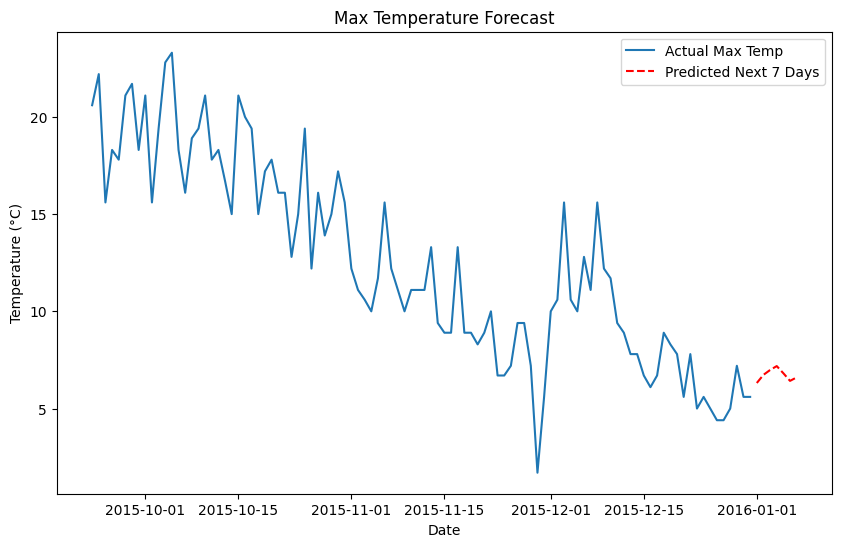

In [34]:
# ==========================
# Visualization
# ==========================
plt.figure(figsize=(10,6))
plt.plot(df['date'].iloc[-100:], df['temp_max'].iloc[-100:], label='Actual Max Temp')
plt.plot(pd.date_range(df['date'].iloc[-1], periods=8, freq='D')[1:], forecast_df['temp_max'], 'r--', label='Predicted Next 7 Days')
plt.title("Max Temperature Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

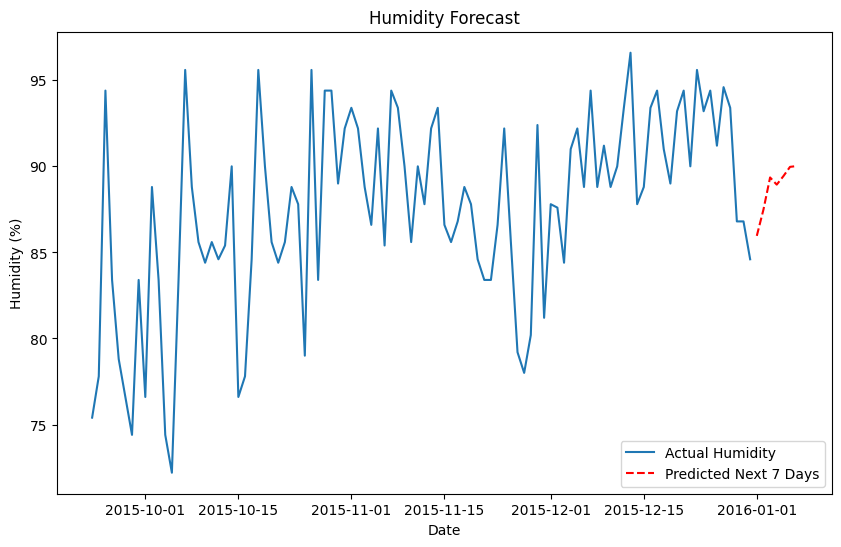

In [35]:
plt.figure(figsize=(10,6))
plt.plot(df['date'].iloc[-100:], df['humidity'].iloc[-100:], label='Actual Humidity')
plt.plot(pd.date_range(df['date'].iloc[-1], periods=8, freq='D')[1:], forecast_df['humidity'], 'r--', label='Predicted Next 7 Days')
plt.title("Humidity Forecast")
plt.xlabel("Date")
plt.ylabel("Humidity (%)")
plt.legend()
plt.show()